<a href="https://colab.research.google.com/github/abelsingla/abelsingla/blob/main/supertrend_demo_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

     |████████████████████████████████| 6.3 MB 6.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=5f3e0d505c2b7915359e2b96e77d05ce2bd86ef3a5b34fa5f109a494c0556c5c
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
atr_period = 10
atr_multiplier = 3.0

stock_list = ['AAPL']
for symbol in stock_list:
    df = yf.download(symbol, start='2020-01-01')
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    df = df.join(supertrend)
df.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Supertrend,Final Lowerband,Final Upperband
Date,,,,,,,,,
2021-09-22,144.449997,146.429993,143.699997,145.850006,145.850006,76404300,False,NaN,152.447216
2021-09-23,146.649994,147.080002,145.639999,146.830002,146.830002,64838200,False,NaN,152.447216
2021-09-24,145.660004,147.470001,145.559998,146.919998,146.919998,53477900,False,NaN,152.447216
2021-09-27,145.470001,145.960007,143.820007,145.369995,145.369995,74150700,False,NaN,152.447216
2021-09-28,143.250000,144.750000,141.690002,141.910004,141.910004,108972300,False,NaN,151.844363
2021-09-29,142.470001,144.449997,142.029999,142.830002,142.830002,74602000,False,NaN,151.763922
2021-09-30,143.660004,144.380005,141.279999,141.500000,141.500000,88934200,False,NaN,151.431535
2021-10-01,141.899994,142.919998,139.110001,142.649994,142.649994,94639600,False,NaN,149.899379
2021-10-04,141.759995,142.210007,138.270004,139.139999,139.139999,98322000,False,NaN,149.549944


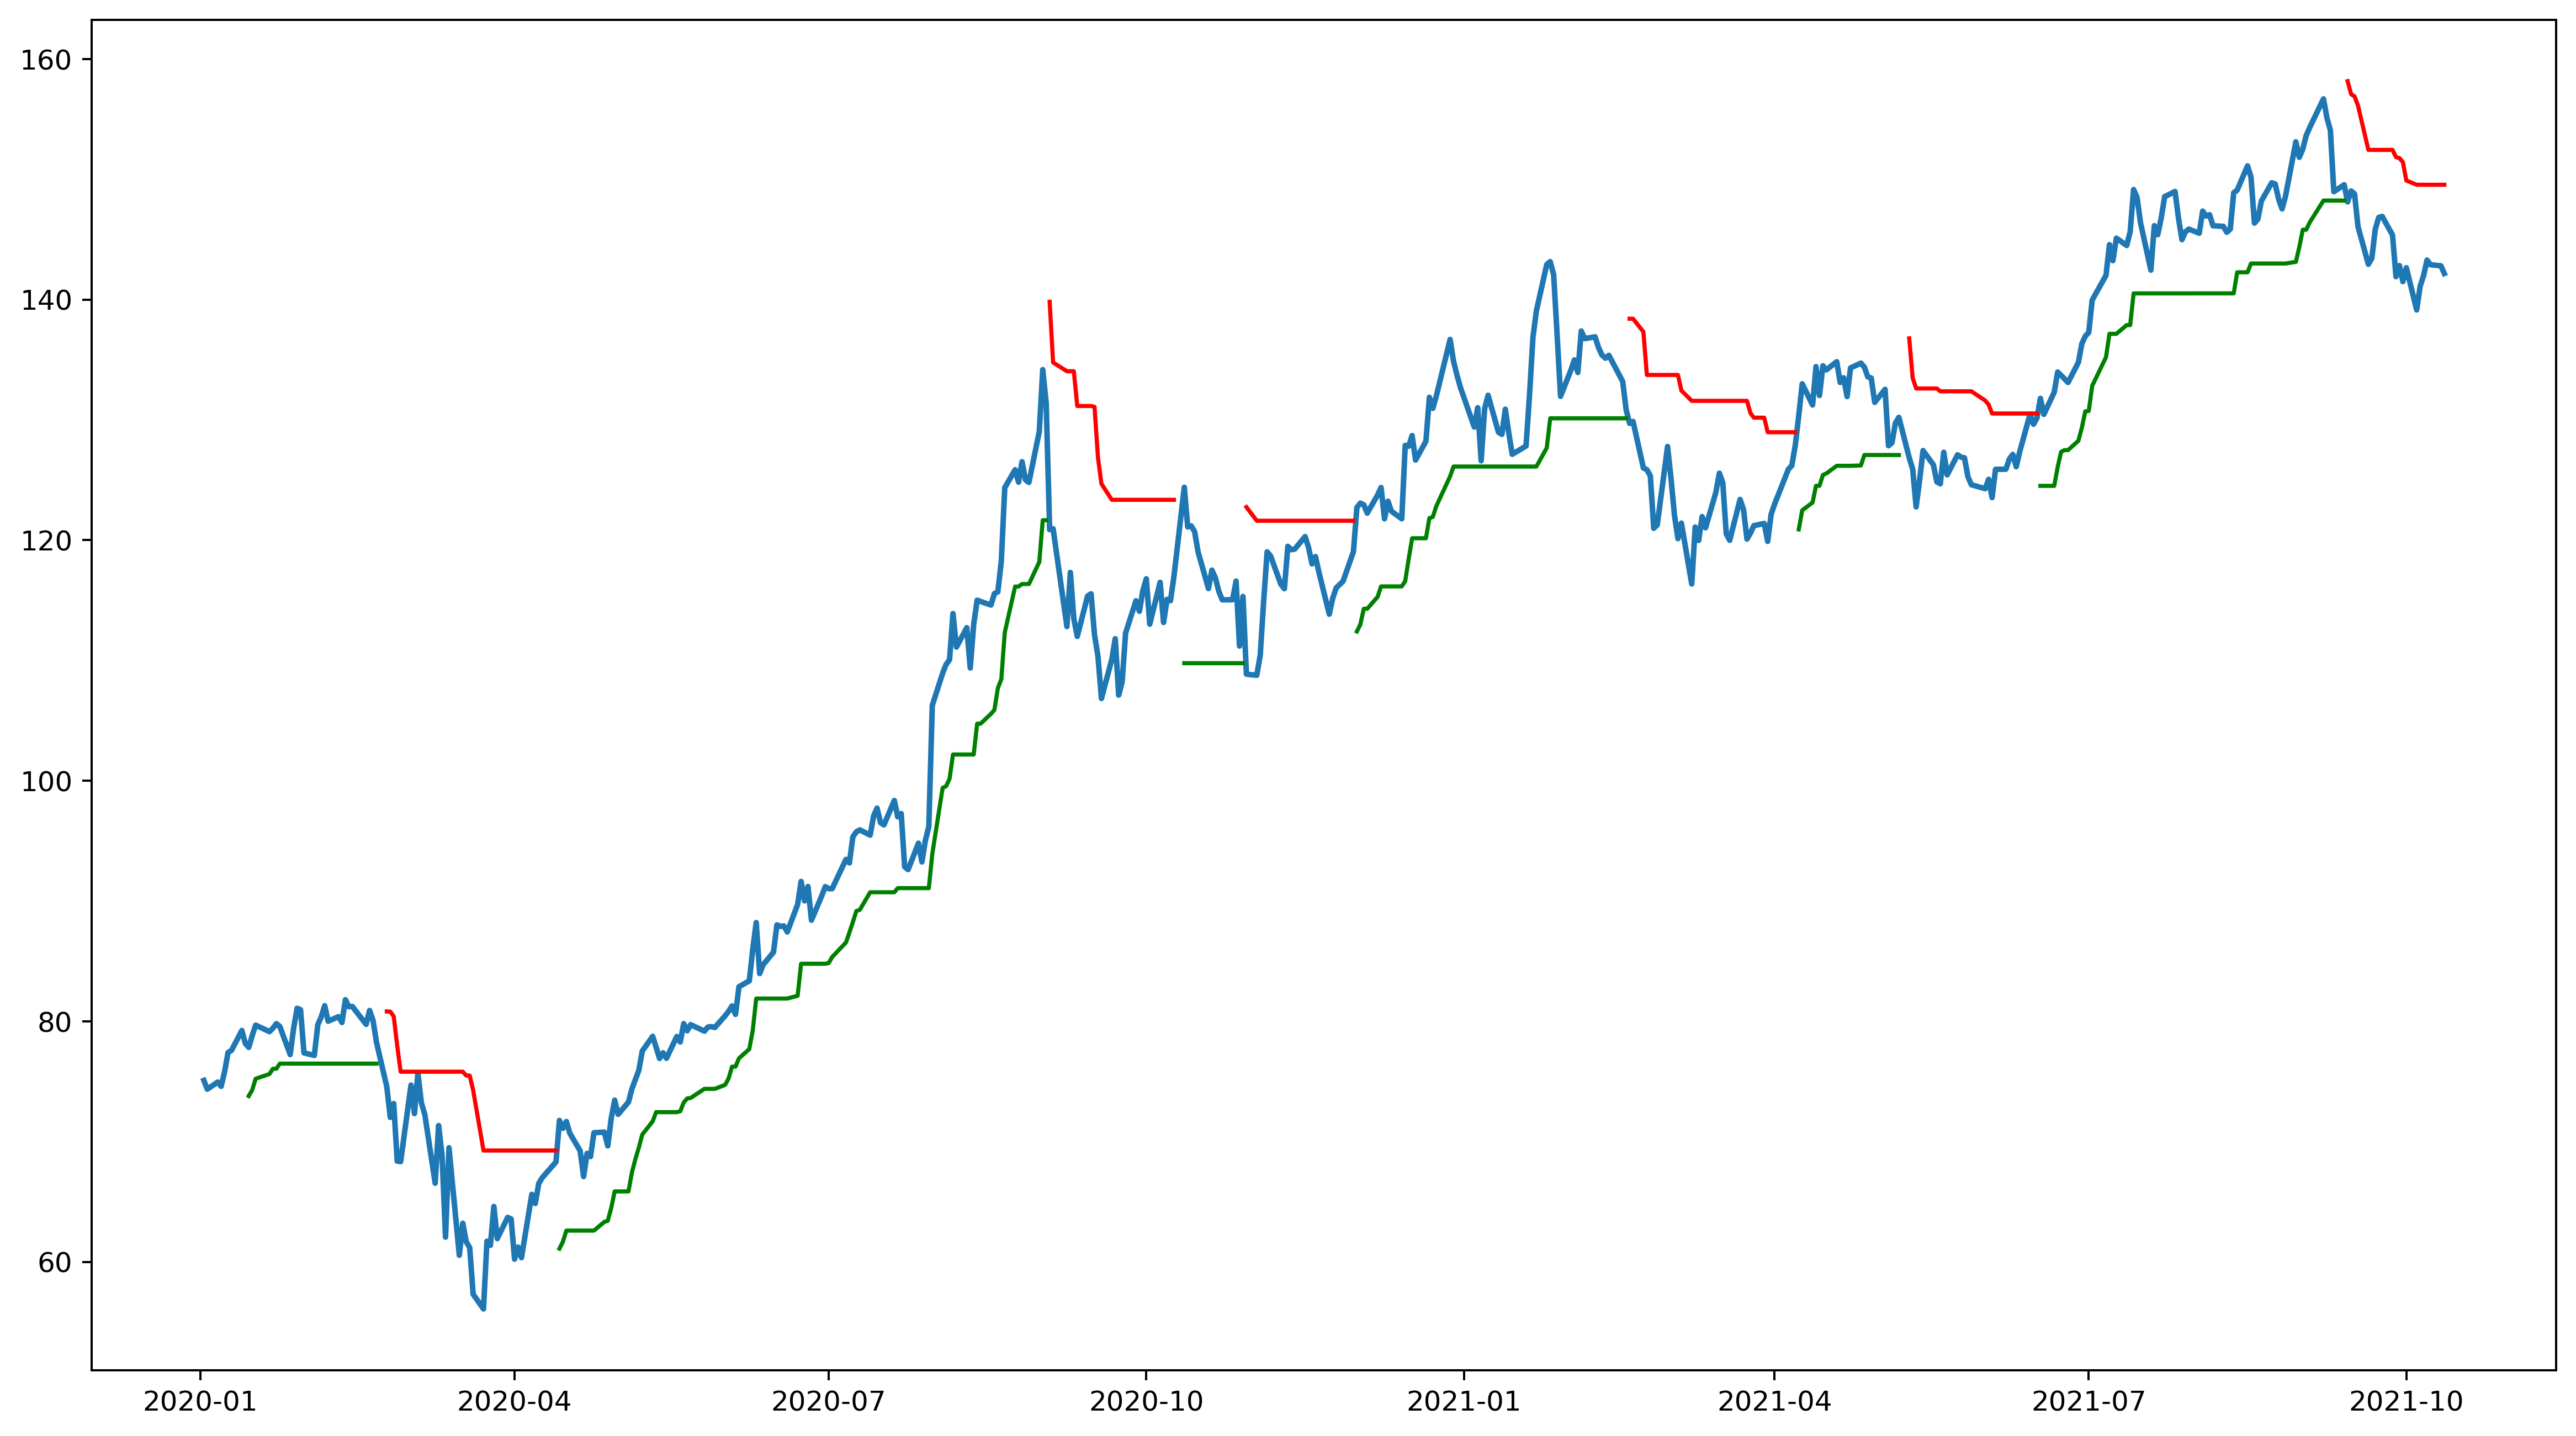

In [3]:
# visualization
plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], linewidth = 2, label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

In [4]:
# backtesting

def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
#             print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
#             print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, roi
entry, exit, roi = backtest_supertrend(df, 100000)

Earning from investing $100k is $64885.26 (ROI = 64.89%)


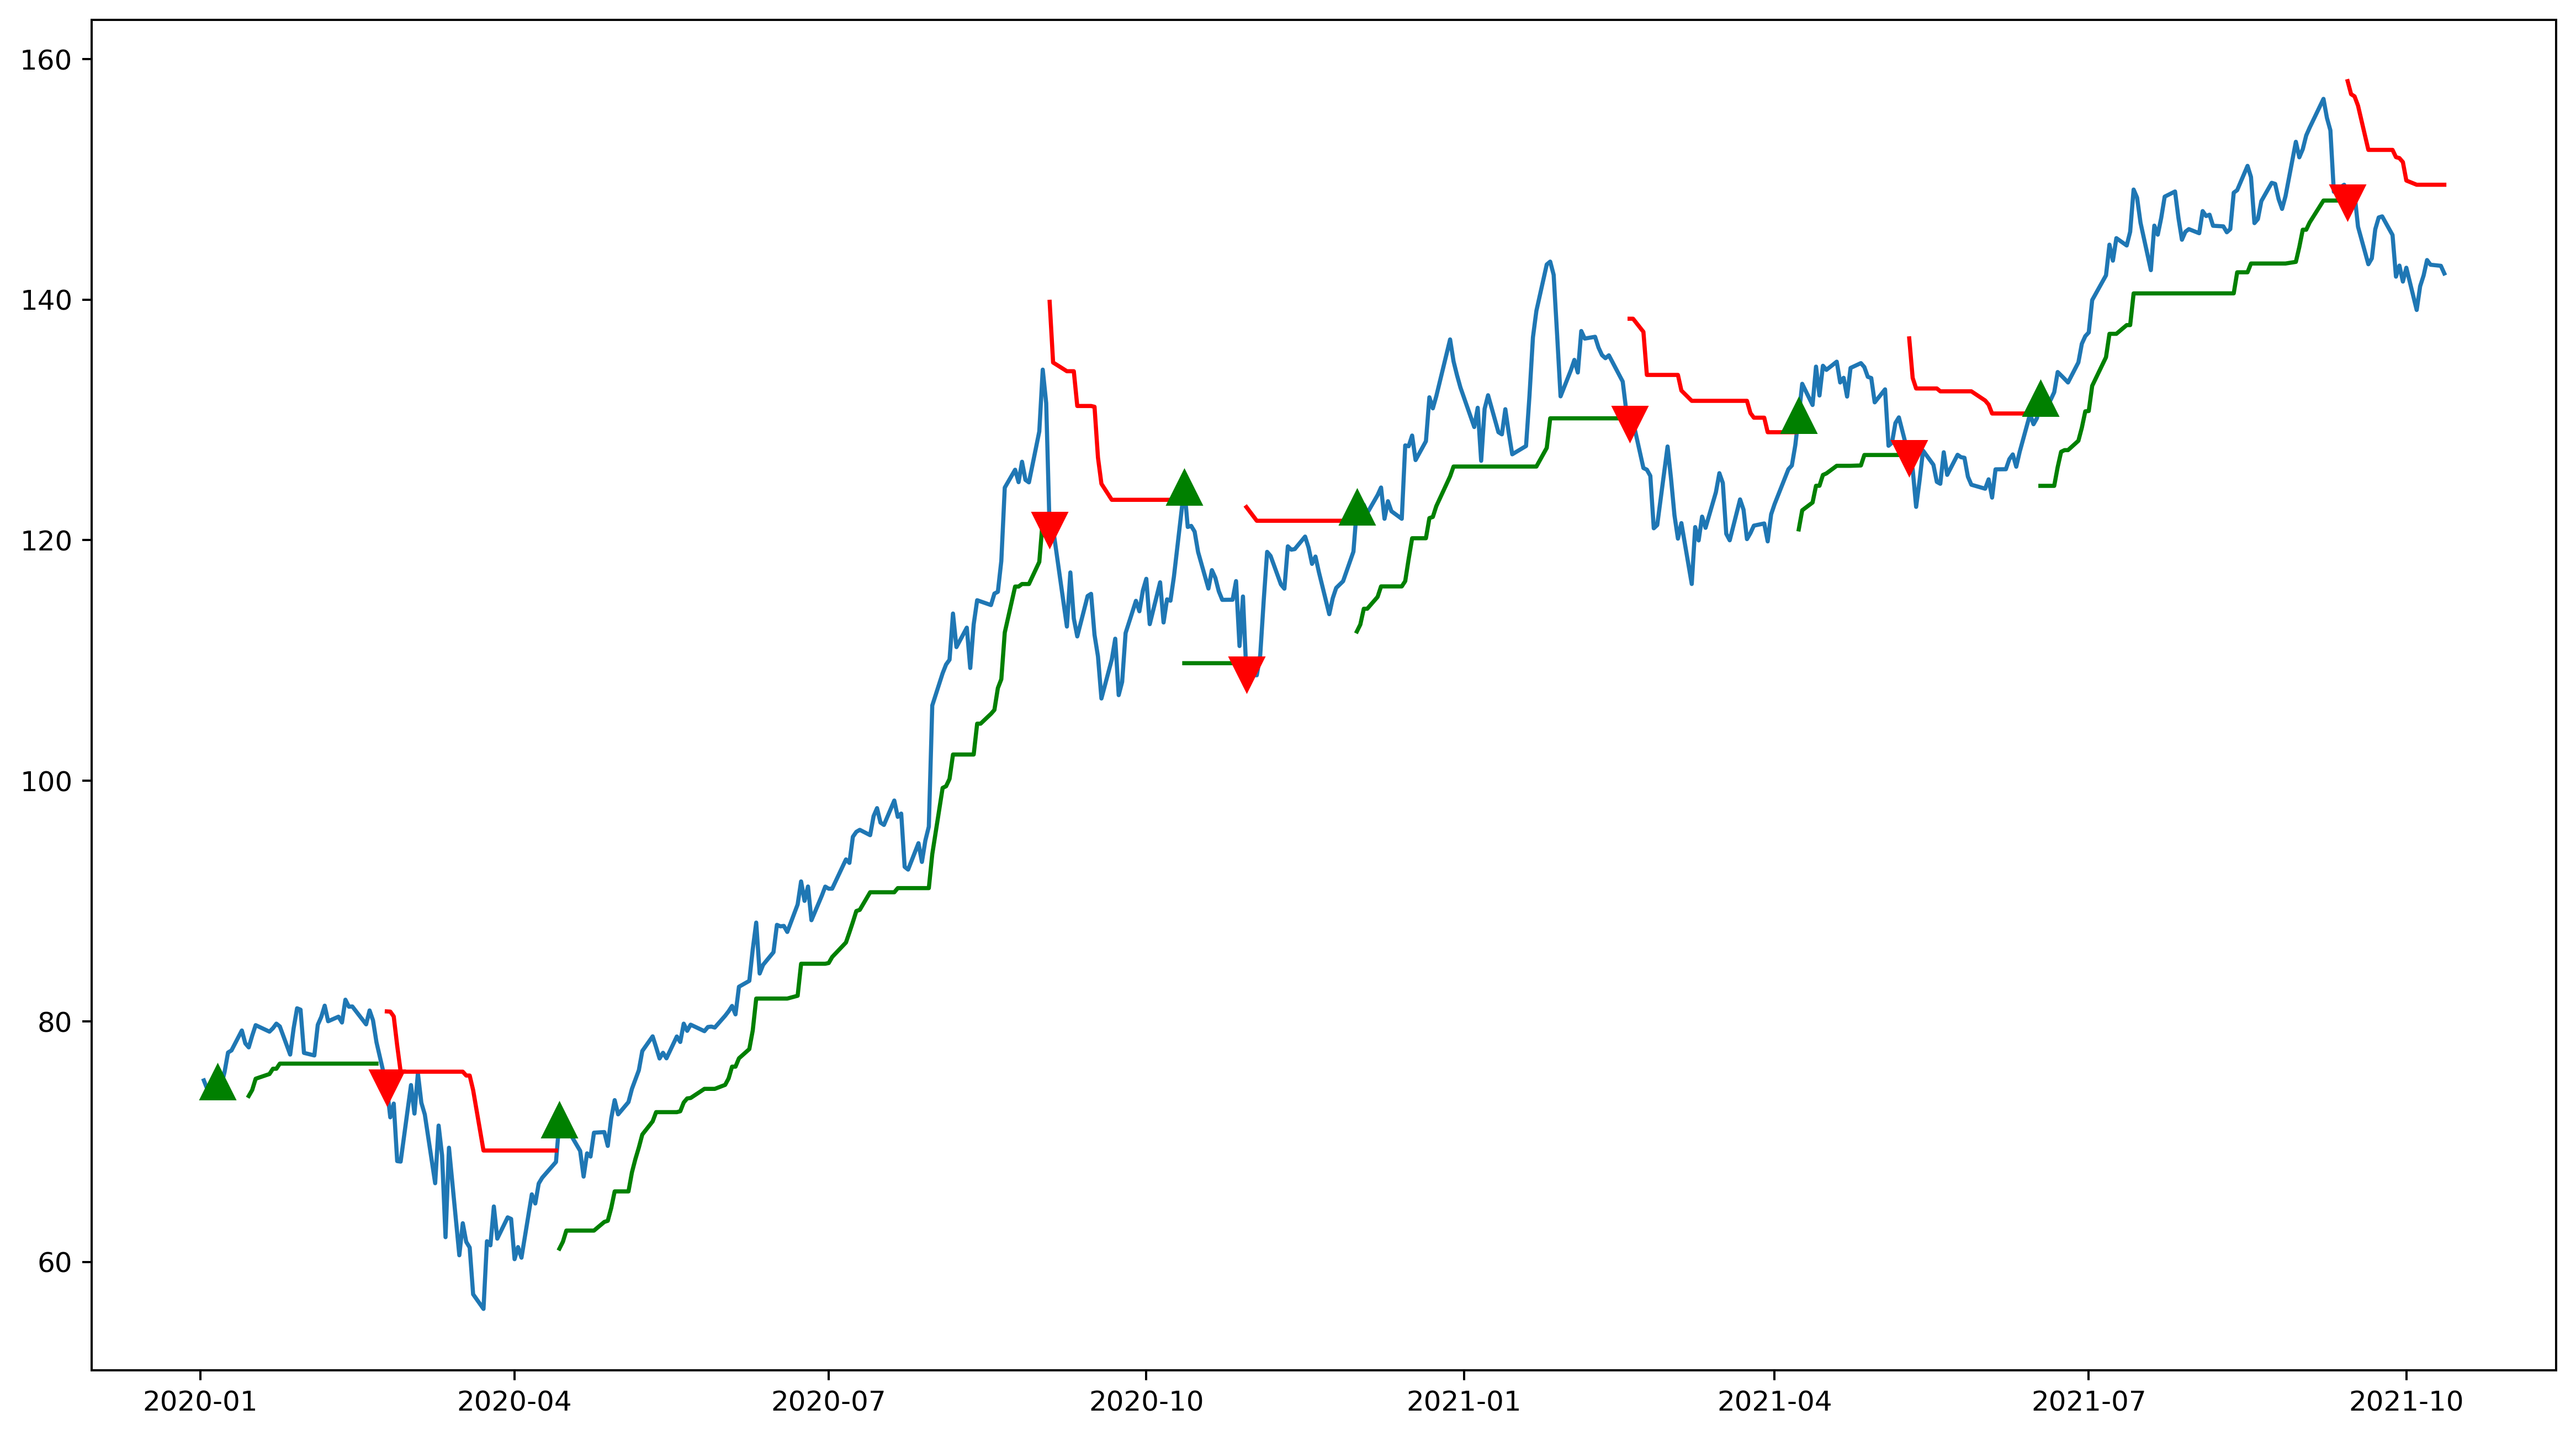

In [5]:
# visualization (for backtest)

plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
for e in entry:
    plt.plot(df.index[e[0]], e[1], marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'Entry')
for e in exit:
    plt.plot(df.index[e[0]], e[1], marker = 'v', color = 'red', markersize = 12, linewidth = 0, label = 'Exit')
plt.show()

In [6]:
# get the full stock list of S&P 500
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_list = payload[0]['Symbol'].values.tolist()

supertrend_stocks = []
# loop through each symbol
for symbol in stock_list:
    df = yf.download(symbol, start='2010-01-01', threads= False)
    if len(df) == 0: continue
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    if not supertrend['Supertrend'][-2] and supertrend['Supertrend'][-1]:
        supertrend_stocks.append(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
for s in supertrend_stocks:
    print(s, end=', ')

APD, BXP, BR, ED, ENPH, GWW, IFF, PEP, PLD, O, VFC, 

In [8]:
# BONUS: parameter optimization
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [7, 8, 9, 10]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0]

    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])

df = yf.download('TSLA', start='2010-01-01')
optimal_param = find_optimal_parameter(df)

print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')

[*********************100%***********************]  1 of 1 completed
Earning from investing $100k is $1101102.05 (ROI = 1101.1%)
Earning from investing $100k is $1069221.6 (ROI = 1069.22%)
Earning from investing $100k is $1571553.75 (ROI = 1571.55%)
Earning from investing $100k is $4325285.2 (ROI = 4325.29%)
Earning from investing $100k is $2229369.28 (ROI = 2229.37%)
Earning from investing $100k is $795810.45 (ROI = 795.81%)
Earning from investing $100k is $791577.27 (ROI = 791.58%)
Earning from investing $100k is $1527594.35 (ROI = 1527.59%)
Earning from investing $100k is $3311993.91 (ROI = 3311.99%)
Earning from investing $100k is $2172912.7 (ROI = 2172.91%)
Earning from investing $100k is $726566.48 (ROI = 726.57%)
Earning from investing $100k is $825562.27 (ROI = 825.56%)
Earning from investing $100k is $1360702.52 (ROI = 1360.7%)
Earning from investing $100k is $2638204.64 (ROI = 2638.2%)
Earning from investing $100k is $2549054.26 (ROI = 2549.05%)
Earning from investing $100k i